In [1]:
import numpy as np, pandas as pd
from scipy import stats # you may or may not need these 2 lines
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df) # you may or may not need this
from __future__ import division
% matplotlib inline
from matplotlib import pyplot as plt
## Parameters for our Logit Demand ##
b0,b1,c_m = 10,-.6, 2.

# Interpreting the coefficient on price
$$\text{Effect of price change on demand}=\frac{d}{dp}\frac{1}{1+e^{-(\beta_0+\beta p_i)}}=\frac{b_1 e^{b_0 + b_1 p}}{(1 + e^{b0 + b1 p})^2}$$



In [2]:
def _derivative_p_(p,b0,b1):
    return b1*np.exp(b0+b1*p)/np.square((1+np.exp(b0+b1*p)))

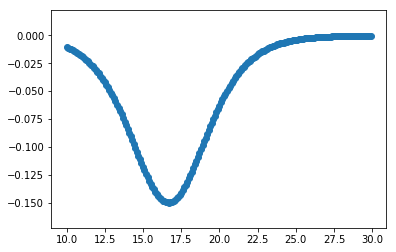

In [3]:
# b0,b1,c_m = 10.855,-.64,2.
prices = np.arange(10,30,.1) # range from 10 to 20 with .1 steps
chgind = [_derivative_p_(p,b0,b1) for p in prices] # compute change in demand
plt.scatter(prices, chgind)

# What about price elasticity?
$$ \text{Elasticity} = \frac{d}{dp}\frac{p}{d}=\frac{b_1 e^{b_0 + b_1 p}}{(1 + e^{b0 + b1 p})^2}\frac{p}{\frac{1}{1+e^{-(\beta_0+\beta p_i)}}}=\frac{b_1 p}{e^{b_0+b_1p}+1}$$

** Note the elasticity depends on b1 and b0! **

In [4]:
def _elasticity_(p,b0,b1):
    return b1*p/(np.exp(b0+b1*p)+1)

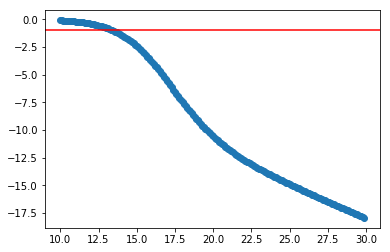

In [5]:
prices = np.arange(10,30,.1) # range from 10 to 20 with .1 steps
elas = [_elasticity_(p,b0,b1) for p in prices] # compute change in demand
plt.scatter(prices, elas)
plt.axhline(y=-1, c = 'r')

# Profit maximization with binary logit demand

$$Pr(U_i>0)=\frac{1}{1+e^{-(\beta_0+\beta p_i)}}=\frac{1}{1+e^{-(10.855-.64 p_i)}}$$

$$E[\Pi]=KPr(U_i>0)\cdot (p-c_m), \text{ where K is the total market size}$$

Note, optimal price should not really depend on K as it multiplies everything, which means when you take the derivative and set equal to 0 to find the maximum, you will end up dropping the K (you divide both sides by K and dividing 0 by K is still 0).

Therefore, we only need to maximize $Pr(U_i>0)\cdot (p-c_m)$ to find the optimal price.

First, we re-write this expression as:

$$\frac{p-c_m}{1+e^{-(\beta_0+\beta p_i)}} $$

Solving for the maximum of this expression is analytically intractable ([See This for more Details](http://ashwin.faculty.ucdavis.edu/wp-content/uploads/sites/169/2014/12/Publication-5.pdf)). **Therefore, we must rely on numerical optimization.**

**SciPy has a convenient numerical optimization function.**

# Example: Solve for profit maximizing price

In [6]:
from scipy.optimize import fmin # import the numerical optimization function
# first we have to define the objective function, this is our profit function
def _profit_function_(p, b0,b1,c_m):
    return (p-c_m)/(1+np.exp(-(b0+b1*p)))

In [7]:
# Next we run the optimization
# b0,b1,c_m = 10, -.6, 2
pstar = fmin(lambda x: -_profit_function_(x, b0,b1,c_m), c_m)[0]  
# the ", c_m" is the starting value that the numerical solver begins its search at
# Why are we using the negative of the profit function??
pstar

Optimization terminated successfully.
         Current function value: -10.011773
         Iterations: 23
         Function evaluations: 46


13.678417968750026

Text(0.5,1,u'Expected Profit Per Visit')

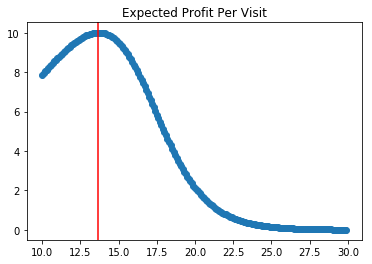

In [8]:
plt.scatter(prices, [_profit_function_(p,b0,b1,c_m) for p in prices])
plt.axvline(x=pstar, color = 'r')
plt.title('Expected Profit Per Visit')

# Adding additional explanatory variables

With logit demand, we have a discrete choice model. In this model, we asume each consumer, $i$, has a common utility function that represents their rational preferences over product attributes, $j$:

$$U_i=\sum_jx_j\beta_j+\epsilon_{i}$$

At least one of these preference attributes, j is price.

Let's rewrite it as:

$$U(x_{i})=\sum_jx_j\beta_j+\alpha p_i+\epsilon_{i}$$

We can let $x$ be any explanatory variable. For example, x_j can be the advertising used, the time of day the item is being displayed, the size of the package, etc.

Assuming the error term $\epsilon\sim \text{Logistic(0,1)}$, we can express the probability of purchase as:

$$Pr(U_i>0)=\frac{1}{1+e^{-(\sum_j{x_j\beta_j}+\alpha p_i)}}$$


## Example, let's simulate some data with  clickthrough search advertisements.
We want to test the effect of prices on demand for customers who arrive at the site following an ad versus organic traffic. Let's randomly assign the price charged each customer. What's the effect of price on probability of purchase? Are customers who follow an ad to the site better or worse? 

Assume marginal cost is \$2 and the cost per click of the ad is \$1.70. Note that this cost is incurred for any visitor, whether or not they bought, as long as they got to the page through the ad.

Utility function:
$$ U_i = \beta_0+\beta_1\text{ad}+\alpha p+\epsilon_{i} $$

Probability of buying:
$$Pr(U_i>0)=\frac{1}{1+e^{-(\beta_0+\beta_1 ad+\alpha p_i)}}$$

Simulation: let $\beta_0=10,\beta_1=1.5,\alpha = -.7,c_m=2, c_{ad} = 1.7$

In [9]:
samplesize = 2000 # Set number of samples
prices = np.random.randint(7,25, size = samplesize) # Randomize prices $7 and $25
ads = np.random.randint(0,2, samplesize) # Randomize ads
epsilon = np.random.logistic(loc=0.0, scale=1.0, size=samplesize) # Random utility shocks

## Set parameters ##
beta1 = 1.5
beta0 = 10
alpha = -.7

c_ad = 1.7
c_m = 2
## Compute individual utilities ##
utilities = beta0+beta1*ads+alpha*prices+epsilon
## Translate utility to chioces (buys when u>0)
choices = [int((np.sign(u)+1)/2) for u in utilities]

# Put data together for what customers see
df = pd.DataFrame(zip(prices, ads, choices),columns = ['Price', 'Ad', 'Buy'] )
df.head()

,Price,Ad,Buy
0,21,0,0
1,20,1,0
2,13,0,1
3,13,0,1
4,23,0,0


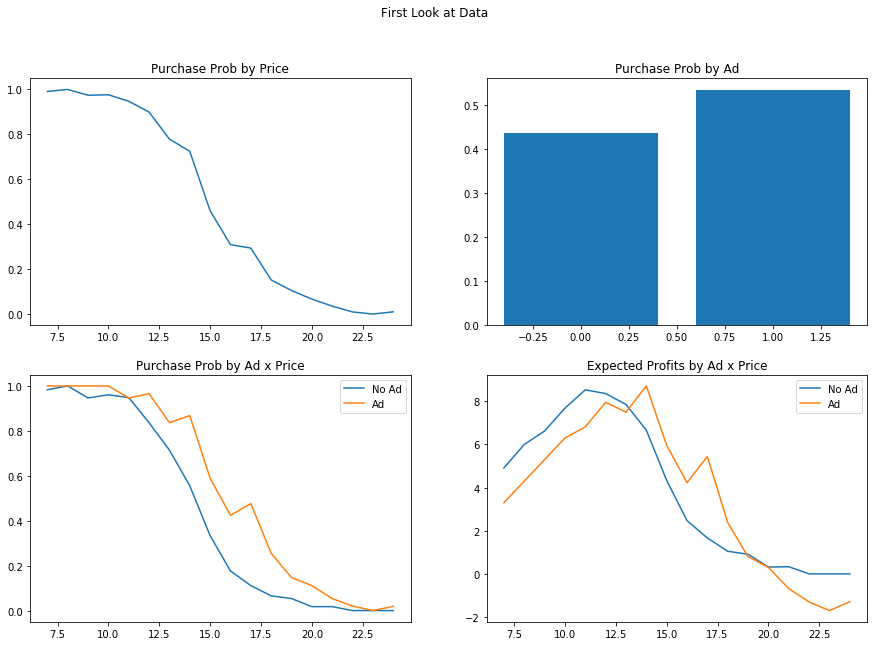

In [10]:
f, axes = plt.subplots(2,2, figsize = (15,10)) # Define figure and axes
f.suptitle('First Look at Data') # Title of figure

# Plot purchase probability by price
axes[(0,0)].plot(df.groupby('Price')['Buy'].mean()) #df.groupby('Price')['Buy'].mean() is the probability of buying for each price
axes[(0,0)].set_title('Purchase Prob by Price') # Label this plot

# Plot purchase probability by Ad
temp = df.groupby('Ad')['Buy'].mean().reset_index()
axes[(0,1)].bar(temp['Ad'], temp['Buy']) # create a bar plot
axes[(0,1)].set_title('Purchase Prob by Ad') 

# Plot purchase probability by both Ad and Price, plot Ad conditions on different lines
# Use price as the x axis
axes[(1,0)].plot(df.groupby(['Ad', 'Price'])[['Buy']].mean().unstack('Ad')) # Unstack creates 2 columns, one for each ad condition (Ad v.s no Ad)
axes[(1,0)].set_title('Purchase Prob by Ad x Price') 
axes[(1,0)].legend(['No Ad', 'Ad']) # Set legend, the first one is no ad, since it is encoded as 0, which comes before 1 (ad condition)

### Compute expected profit using observed data####
# First, we groupby ad and price, then average the Buy dummy variable
# This gives us probability of purchase for each ad x price condition
# We reset index so we can use Ads and Prices as columns to compute expected profits
temp = df.groupby(['Ad', 'Price'])[['Buy']].mean().reset_index()
# Compute expected profits for each row, x. 
# We do this w/ a lambda function
# e.g. x['buy'] is the buy variable for each row x
# Note we have to specify, axis =1
# Expected Profit = Prob(Buying)*(Price-Marginal Cost)-Ad Cost
temp['Expected_Profit']=temp.apply(lambda x: x['Buy']*(x['Price']-c_m)-x['Ad']*c_ad, axis =1)

axes[(1,1)].plot(temp.groupby(['Ad', 'Price'])[['Expected_Profit']].mean().unstack('Ad'))
axes[(1,1)].set_title('Expected Profits by Ad x Price')
axes[(1,1)].legend(['No Ad', 'Ad'])

### Assume the simulated data is all we see, let's estimate the logit demand function

In [11]:
import statsmodels.api as sm

C:\Users\Yang\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
df.head()

,Price,Ad,Buy
0,21,0,0
1,20,1,0
2,13,0,1
3,13,0,1
4,23,0,0


In [13]:
results = sm.Logit(df.Buy, sm.add_constant(df[['Ad', 'Price']])).fit() # estimate logit model

Optimization terminated successfully.
         Current function value: 0.274843
         Iterations 8


In [14]:
results.summary() # Show Estimated Parameters

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Buy   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1997
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Apr 2018   Pseudo R-squ.:                  0.6032
Time:                        13:10:05   Log-Likelihood:                -549.69
converged:                       True   LL-Null:                       -1385.3
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4624      0.431     21.945      0.000       8.617      10.308
Ad             1.3394      0.165      8.098      0.000       1.015       1.664
Price         -0.6658      0.029    -22.750      0.000      -0.723      -0.608
==============================================================================
"""

## Okay, now let's find the profit maximizing price

First, we have to point out that there may be a different profit maximizing price for Ads vs. No Ads.

1. Expected Profit for No Ads: Prob(buying | No Ad)*(price-marginal cost)
2. Expected Profit for Ads: Prob(buying | Ad)*(price-marginal cost)-Ad cost

Let's define 2 expected profit functions, one for ads, one for no ads.

In [15]:
def _e_prof_noad_(p, b0,alpha, c_m):
    return (p-c_m)/(1+np.exp(-(b0+alpha*p)))

def _e_prof_ad_(p, b0,b1,alpha, c_m,c_ad):
    return (p-c_m)/(1+np.exp(-(b0+b1+alpha*p)))-c_ad

In [16]:
b0,b1,alpha = results.params # Grab estimated parameters from Logit results

In [17]:
pstar_noad = fmin(lambda x: -_e_prof_noad_(x, b0,alpha,c_m), c_m)[0]  
profstar_noad = _e_prof_noad_(pstar_noad, b0,alpha,c_m)
pstar_ad = fmin(lambda x: -_e_prof_ad_(x, b0,b1,alpha, c_m, c_ad), c_m+c_ad)[0]
profstar_ad = _e_prof_noad_(pstar_ad, b0,b1,c_m)

print 'No ad profit maximized at price = '+str(pstar_noad)+', profits are '+str(profstar_noad)
print 'Ad profit maximized at price = '+str(pstar_ad)+', profits are '+str(profstar_ad)

Optimization terminated successfully.
         Current function value: -8.167109
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: -8.191208
         Iterations: 21
         Function evaluations: 42
No ad profit maximized at price = 11.66914062500002, profits are 8.167108817399875
Ad profit maximized at price = 13.393168945312517, profits are 11.393168945298184


Text(0.5,1,u'Expected Profits by Ad x Price')

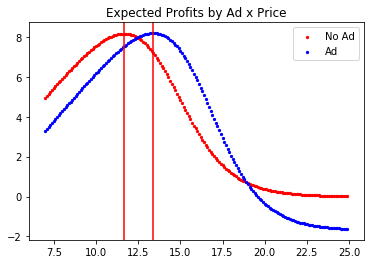

In [18]:
prices = np.arange(7,25,.1)
profits_noad = [_e_prof_noad_(p, b0,alpha,c_m) for p in prices]
profits_ad = [_e_prof_ad_(p, b0,b1,alpha, c_m,c_ad) for p in prices]
plt.scatter(prices, profits_noad, s = 5, c='r') # "s" controls the dots' opacity
plt.scatter(prices, profits_ad, s = 5, c='b') 
plt.legend(['No Ad', 'Ad'])
plt.axvline(x=pstar_noad, color = 'r')
plt.axvline(x=pstar_ad, color = 'r')
plt.title('Expected Profits by Ad x Price')